In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import find_peaks
from scipy.fftpack import fft
from scipy.fftpack import dct
import os
import csv

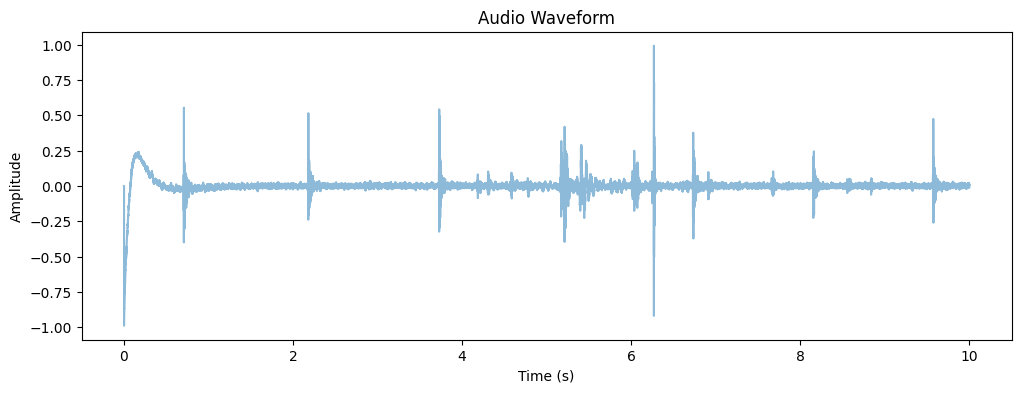

Detected hits at: [0.70988662 2.18154195 3.72938776 5.2124263  6.26888889 6.73358277
 9.57310658] seconds
Saved segment 1: 1_hit_1.wav
Saved segment 2: 1_hit_2.wav
Saved segment 3: 1_hit_3.wav
Saved segment 4: 1_hit_4.wav
Saved segment 5: 1_hit_5.wav
Saved segment 6: 1_hit_6.wav
Saved segment 7: 1_hit_7.wav


In [5]:
# Load the audio file
file_path = r"C:\Users\kanup\OneDrive\Desktop\Data - Axe\1.wav" 
sample_rate, signal = wavfile.read(file_path)

# Get the base file name (without extension) to use in segment names
base_name = os.path.splitext(os.path.basename(file_path))[0]

# If the signal has multiple channels, convert it to mono
if len(signal.shape) > 1:
    signal = signal.mean(axis=1)

# Normalize the signal
if signal.dtype == np.int16:
    signal = signal / 32768.0
elif signal.dtype == np.int32:
    signal = signal / 2147483648.0

# Plot the waveform to visualize
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, len(signal) / sample_rate, len(signal)), signal, alpha=0.5)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Detect peaks in the signal for segmentation
peaks, _ = find_peaks(signal, height=0.3, distance=sample_rate // 4)  # Adjust height and distance
peak_times = peaks / sample_rate  # Convert peak indices to time
print(f"Detected hits at: {peak_times} seconds")

# Split the audio into segments based on peaks
segments = []
for i, peak in enumerate(peaks):
    start_sample = int(peak - 0.2 * sample_rate)  # 200ms before the peak
    end_sample = int(peak + 0.2 * sample_rate)   # 200ms after the peak
    start_sample = max(0, start_sample)
    end_sample = min(len(signal), end_sample)
    
    segments.append(signal[start_sample:end_sample])
    
    # Save each segment as a new .wav file with the base name and hit number
    output_filename = f"{base_name}_hit_{i + 1}.wav"
    wavfile.write(output_filename, sample_rate, (segments[-1] * 32767).astype(np.int16))
    print(f"Saved segment {i + 1}: {output_filename}")


In [7]:
# Function to compute MFCCs without librosa
def compute_mfcc(signal, sr, n_mfcc=13, n_fft=2048, hop_length=512):
    # Pre-emphasis filter
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # Frame the signal
    frame_length = int(0.025 * sr)
    frame_step = int(0.01 * sr)
    signal_length = len(emphasized_signal)
    frame_count = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
    pad_signal_length = frame_count * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)

    indices = np.tile(np.arange(0, frame_length), (frame_count, 1)) + np.tile(np.arange(0, frame_count * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Apply Hamming window
    frames *= np.hamming(frame_length)

    # FFT and Power Spectrum
    NFFT = n_fft
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))  # Power Spectrum

    # Filter Banks
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sr)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # Left
        f_m = int(bin[m])             # Center
        f_m_plus = int(bin[m + 1])    # Right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
            
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB

    # MFCCs
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, :n_mfcc]
    return mfcc

# Feature extraction function
def extract_features(segment, sr):
    features = {}
    # Temporal features
    features['skewness'] = np.mean(((segment - np.mean(segment)) / np.std(segment))**3)
    features['std_dev'] = np.std(segment)
    features['min_peak'] = np.min(segment)
    features['max_peak'] = np.max(segment)
    features['zcr'] = np.mean(np.abs(np.diff(np.sign(segment))) / 2)
    features['peak_to_peak_amplitude'] = np.max(segment) - np.min(segment)
    features['rms_energy'] = np.sqrt(np.mean(segment**2))

    # Spectral features using FFT
    fft_vals = np.abs(fft(segment))
    fft_freqs = np.fft.fftfreq(len(segment), 1 / sr)

    # Compute spectral centroid
    spectral_centroid = np.sum(fft_freqs * fft_vals) / np.sum(fft_vals)
    features['spectral_centroid'] = spectral_centroid
    
    # Compute spectral rolloff (85% of energy)
    cumulative_energy = np.cumsum(fft_vals**2)
    total_energy = cumulative_energy[-1]
    rolloff_index = np.where(cumulative_energy >= 0.85 * total_energy)[0][0]
    features['spectral_rolloff'] = fft_freqs[rolloff_index]

    # Compute spectral bandwidth
    spectral_bandwidth = np.sqrt(np.sum(((fft_freqs - spectral_centroid)**2) * fft_vals) / np.sum(fft_vals))
    features['spectral_bandwidth'] = spectral_bandwidth

    # Compute spectral energy
    spectral_energy = np.sum(fft_vals**2)
    features['spectral_energy'] = spectral_energy

    # Compute MFCCs without librosa
    mfccs = compute_mfcc(segment, sr, n_mfcc=13)
    features['mfcc'] = mfccs.mean(axis=0).tolist()  # Mean of each MFCC coefficient

    return features

# Process each segment and extract features
all_features = []
for i, segment in enumerate(segments):
    features = extract_features(segment, sample_rate)
    all_features.append(features)
    print(f"Features of Segment {i + 1}: {features}")

# Save features to a CSV file using the base name of the input audio file
base_name = os.path.splitext(os.path.basename(file_path))[0]
output_csv = f"{base_name}_hit_features.csv"

with open(output_csv, "w", newline="") as csvfile:
    fieldnames = list(all_features[0].keys())
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(all_features)

print(f"Feature extraction complete. Features saved to {output_csv}.")


Features of Segment 1: {'skewness': np.float64(2.319419592089938), 'std_dev': np.float64(0.03530688909584218), 'min_peak': np.float64(-0.399261474609375), 'max_peak': np.float64(0.5540771484375), 'zcr': np.float64(0.00946765689664947), 'peak_to_peak_amplitude': np.float64(0.953338623046875), 'rms_energy': np.float64(0.03974524811704686), 'spectral_centroid': np.float64(-0.149259431270088), 'spectral_rolloff': np.float64(-272.5), 'spectral_bandwidth': np.float64(4274.858681626861), 'spectral_energy': np.float64(491549.8711256684), 'mfcc': [-636.8980885371999, -28.612036450147684, 28.13577442733773, -11.92571335662096, 4.85227481707777, 8.499442303485935, 3.653168251139274, 5.976530130474266, -3.0906217000288683, -1.2112971206064238, 0.5591044445286382, 4.457481001874234, 1.3082716633730513]}
Features of Segment 2: {'skewness': np.float64(3.131559075849858), 'std_dev': np.float64(0.031739506553295535), 'min_peak': np.float64(-0.239044189453125), 'max_peak': np.float64(0.514373779296875),